In [1]:
import gym
from carpole import select_action
from policy import PolicyNetwork
import torch
import torch.optim as optim


In [2]:
discount_factor = 0.99

num_episodes = 1000

max_steps = 10_000

device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
env = gym.make('CartPole-v1')

#Init network
network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(device)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=1e-2)


In [23]:
state, info = env.reset()

select_action(network, state, device)

(0, tensor([-0.6217], grad_fn=<SqueezeBackward1>))

In [26]:
from tqdm.notebook import tqdm
#track scores
scores = []

#iterate through episodes
for episode in tqdm(range(num_episodes)):

    #reset environment, initiable variables
    state, info = env.reset()
    rewards = []
    log_probs = []
    score = 0

    #generate episode
    for step in range(max_steps):
        env.render()

        #select action
        action, lp = select_action(network, state, device)

        #execute action
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        #track episode score
        score += reward

        #store reward and log probability
        rewards.append(reward)
        log_probs.append(lp)

        #end episode
        if done:
            break

        #move into new state
        state = new_state

    #append score
    scores.append(score)

    #Calculate Gt (cumulative discounted rewards)
    discounted_rewards = []

    #track cumulative reward
    total_r = 0

    #iterate rewards from Gt to G0
    for r in reversed(rewards):

        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r ** discount_factor

        #append to discounted rewards
        discounted_rewards.append(total_r)

    #reverse discounted rewards
    rewards = torch.tensor(discounted_rewards).to(device)
    rewards = torch.flip(rewards, [0])

    #adjusting policy parameters with gradient ascent
    loss = []
    for r, lp in zip(rewards, log_probs):
        #we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        loss.append(-r * lp)

    #Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    optimizer.step()

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\aalcacer\Miniconda3\envs\reinforcement-learning\lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


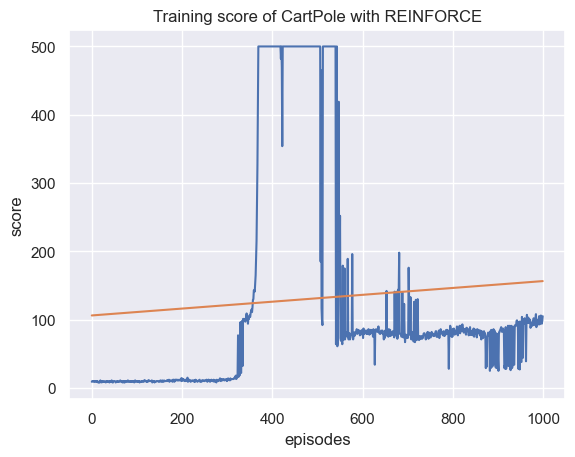

In [28]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()